Let's train a very simple non-linear multivariate regression model using PyTorch.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

Create a simple PyTorch Module. This Module models the function:

$y = M_2 (M_1 x + b_1) + b_2$

And you want to minimize:

$L = || y - y_{observed} ||^2 + \lambda_1 ||M_1||_F + + \lambda_2 ||M_2||_F$

where $x$ and $y$ are vectors and we're taking the Frobenius norm of our parameters. 

Note that $M_1$ and $M_2$ aren't necessarily square. In fact, if we set the shapes of $M_1$ and $M_2$ to be small we can try to "squeeze" into a smaller space and effectively build-in dimensionality reduction.

This whole model is slightly more complicated than vanilla linear regression, and is now something like quadratic (because of the two matrix multiplies) vector regression (because we're predicting a vector outcome, not a scalar one).

We can split the above model into three steps, which (1) initialize parameters, (2) compute a prediction, and (3) compute the loss.

- Declare that you'll be optimizing two linear functions. This saves space for $M_1$, $M_2$, $b_1$ and $b_2$, but not $x$ or $y$. Putting it in the `__init__` function of a `nn.Module` is special: PyTorch will remember that these parameters are optimize-able.
- `forward` tells us how to combine our parameters to make a prediction $y$
- `loss` tells us how to compare our prediction vector to our observed vector, plus how to minimize our regularizer.

In [2]:
class Bottleneck(nn.Module):
    def __init__(self, n_in_cols, n_out_cols, n_hidden=3):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(n_in_cols, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_out_cols)
    
    def forward(self, x):
        # x is a minibatch of rows of our features
        hidden = self.lin1(x)
        # y is a minibatch of our predictions
        y = self.lin2(hidden)
        return y

    def loss(self, prediction, target, lam1=1e-3, lam2=1e-3):
        # This is just the mean squared error
        loss_likelihood = ((prediction - target)**2.0).sum()
        # This computes our Frobenius norm over both matrices
        # Note that we can access the Linear model's variables
        # directly if we'd like. No tricks here!
        loss_prior_m1 = (self.lin1.weight**2.0 * lam1).sum()
        loss_prior_m2 = (self.lin2.weight**2.0 * lam2).sum()
        loss = loss_likelihood + loss_prior_m1 + loss_prior_m2
        return loss

Let's make up some fake data to fit. Annoyingly, it has to be `float32` or `int64`.

In [3]:
X = np.random.normal(size=(2000, 9)).astype(np.float32)
Y = np.random.normal(size=(2000, 4)) + np.dot(X, np.random.normal(size=(9, 4)))
Y = Y.astype(np.float32)

In [4]:
X.shape, Y.shape

((2000, 9), (2000, 4))

Initialize the model. Note that we'll also initialize the "optimizer". Check out [this link](http://ruder.io/optimizing-gradient-descent/) to learn more about different optimizers. For now, `Adam` is a good choice.

In [5]:
model = Bottleneck(9, 4, 3)
o = optim.Adam(model.parameters())

In [6]:
model.lin1.weight.data.shape

torch.Size([3, 9])

In [7]:
model.lin2.weight.data.shape

torch.Size([4, 3])

In [8]:
model.lin1.bias.data.shape

torch.Size([3])

In [9]:
from random import shuffle

def chunks(X, Y, size):
    """Yield successive n-sized chunks from l."""
    starts = list(range(0, len(X), size))
    shuffle(starts)
    for i in starts:
        yield (X[i:i + size], Y[i:i + size])

In [16]:
batch_size = 64
losses = []
for epoch in range(400):
    for itr, (feature, target) in enumerate(chunks(X, Y, batch_size)):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        o.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target))
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        # break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.

        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        o.step()
        # Record the loss per example
        losses.append(loss.data.numpy() / len(feature))
        if epoch % 10 == 0 and itr ==0:
            print(epoch, loss.data)


0 tensor(389.3312)
10 tensor(353.0794)
20 tensor(349.8586)
30 tensor(406.9885)
40 tensor(399.0048)
50 tensor(415.3995)
60 tensor(351.9067)
70 tensor(390.0703)
80 tensor(350.2450)
90 tensor(332.8827)
100 tensor(352.1260)
110 tensor(351.9948)
120 tensor(415.3929)
130 tensor(406.6318)
140 tensor(378.3241)
150 tensor(333.1018)
160 tensor(314.1754)
170 tensor(374.8451)
180 tensor(353.8031)
190 tensor(314.1478)
200 tensor(351.8117)
210 tensor(375.3241)
220 tensor(381.6292)
230 tensor(351.4853)
240 tensor(389.8167)
250 tensor(314.3240)
260 tensor(352.4277)
270 tensor(302.2336)
280 tensor(372.0277)
290 tensor(376.9128)
300 tensor(377.1186)
310 tensor(337.9866)
320 tensor(331.7121)
330 tensor(351.7342)
340 tensor(381.2636)
350 tensor(491.7418)
360 tensor(351.3787)
370 tensor(406.8087)
380 tensor(371.4063)
390 tensor(116.6104)


I can introspect my model and get the parameters out:

In [83]:
model.lin1.weight.data.numpy()

array([[-0.3915055 ,  1.0909117 ,  0.7181141 , -0.70651376, -0.425953  ,
        -0.47559333, -0.61746806,  0.70269215,  0.6047616 ],
       [-0.25109383,  0.4693849 , -0.05878725,  0.7238346 , -0.41165322,
         0.7268368 , -0.36824784,  0.824761  , -0.5482797 ],
       [ 0.46500823,  1.0385923 ,  0.18565843,  0.8508095 ,  0.27644953,
         0.14546989, -0.09419439, -0.30632475, -0.07996742]],
      dtype=float32)

In [84]:
model.lin1.bias.data.numpy()

array([0.04460083, 0.24982159, 0.02115883], dtype=float32)

I can also see that the loss is simply a scalar:

In [85]:
loss

tensor(358.7330, grad_fn=<AddBackward0>)

You can see that the gradient is zero before we call `loss.backward()`

In [86]:
model.lin1.bias.grad

tensor([ 36.5766,   8.1368, -11.6025])

...And non-zero afterwards.

In [87]:
model.lin1.bias.grad

tensor([ 36.5766,   8.1368, -11.6025])

In [88]:
model.lin1.bias.data

tensor([0.0446, 0.2498, 0.0212])

And after we run `o.step()` we'll notice that the bias parameter has been updated:

In [89]:
model.lin1.bias.data.numpy()

array([0.04460083, 0.24982159, 0.02115883], dtype=float32)

Let's check on convergence:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

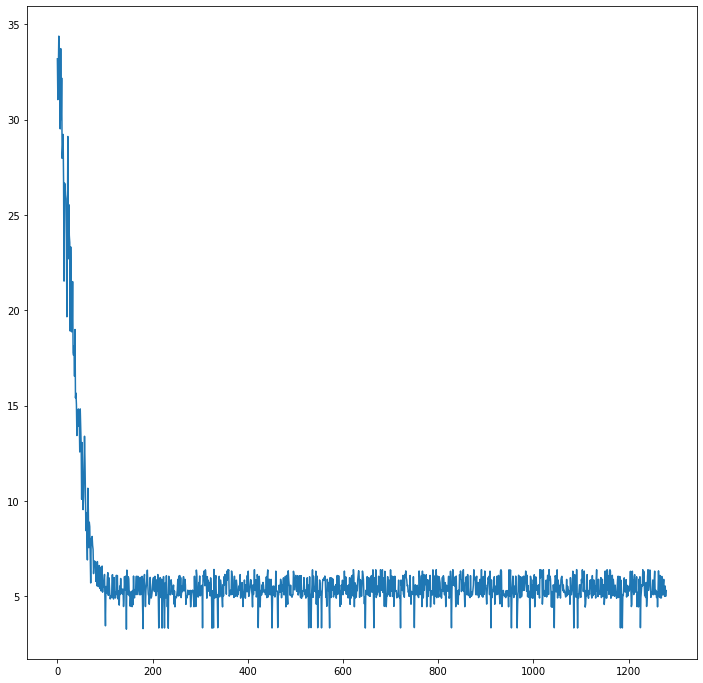

In [91]:
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses[::10])
plt.plot(smooth, c='r')

Looks converged to me!

## Using PyTorch Lightning

After you've  written a dozen  pytorch models you'll discover that there's a lot of common structure and a huge amount of boilerplate. It's good to understand what's going on undere the hood, but when moving to production use cases you'll want to opt for more reliable, reproducible code. PyTorch Lightning & Ignite are great libraries that abstract away these core bits.

To install the libraries:

    pip uninstall tensorboard
    conda install tensorboard -y
    conda install pytorch-lightning -y -c conda-forge

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np

# X is just a 9D normally distributed dataset
X = np.random.normal(size=(2000, 9)).astype(np.float32)
# The prediction is a linear transformation on X
# from 9D to 4D plus additive noise
Y = np.random.normal(size=(2000, 4)) * 1e-2 + np.dot(X, np.random.normal(size=(9, 4)))
Y = Y.astype(np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1500, 9), (500, 9), (1500, 4), (500, 4))

Let's write our initial model as Lightning  module:

Don't be afraid of how much extra code this injects. Although it  initially looks like a ton of little class functions, it's all about being organized, deliberate, standardized and repeatable. It's not about science, it's about having good lab hygiene. 

- We'll move some of the iteration code into `training_step`  and `test_step`, and `test_epoch_end`.
- Add in a `configure_optimizers` function.
- Separate out train & test loaders

In [16]:
import torch
import numpy as np
from random import shuffle
import pytorch_lightning as pl


def chunks(*arrays, size):
    """Yield successive n-sized chunks from l."""
    starts = list(range(0, len(arrays[0]), size))
    # always visit your data in a random order!
    shuffle(starts)
    for i in starts:
        arrs = [arr[i: i + size] for arr in arrays]
        # convert numpy arrays to torch arrays
        arrs_torch = []
        for arr in arrs:
            if arr.dtype != np.dtype('O'):
                tarr = torch.from_numpy(arr)
                arrs_torch.append(tarr)
            else:
                arrs_torch.append(arr)
        yield arrs_torch[:-1], arrs_torch[-1]


class AbstractModel(pl.LightningModule):
    def save_data(self, train_x, train_y, test_x, test_y, train_d=None, test_d=None):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.train_d = train_d
        self.test_d = test_d

    def training_step(self, batch, batch_nb):
        input, target = batch
        prediction = self.forward(input)
        loss = self.likelihood(prediction, target) + self.prior()
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        input, target = batch
        prediction = self.forward(input)
        # Note that we do *not* include the regularization / prior loss
        # at test time
        loss = self.likelihood(prediction, target)
        tensorboard_logs = {'test_loss': loss}
        return {'test_loss': loss, 'log': tensorboard_logs}
    
    def test_epoch_end(self, outputs):
        test_loss_mean = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'test_loss': test_loss_mean}
    
    def train_dataloader(self):
        if self.train_d is None:
            return chunks(self.train_x, self.train_y, size=self.batch_size)
        else:
            return chunks(self.train_x, self.train_d, self.train_y, size=self.batch_size)
        
    def test_dataloader(self):
        if self.test_d is None:
            return chunks(self.test_x, self.test_y, size=self.batch_size)
        else:
            return chunks(self.test_x, self.test_d, self.test_y, size=self.batch_size)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)


And then we'll keep out `Bottleneck` model, but now it will inherit from our `AbstractModel`. Over the next few notebooks we'll keep using the `AbstractModel` class and just stick to focusing  our changes within the subclasses.

In [17]:
class Bottleneck(AbstractModel):
    def __init__(self, n_in_cols, n_out_cols, n_hidden=3, batch_size=128):
        super().__init__()
        self.lin1 = nn.Linear(n_in_cols, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_out_cols)
        self.batch_size = batch_size
    
    def forward(self, x):
        # x is a minibatch of rows of our features
        hidden = self.lin1(x)
        # y is a minibatch of our predictions
        y = self.lin2(hidden)
        return y

    def loss(self, prediction, target, lam1=1e-3, lam2=1e-3):
        # This is just the mean squared error
        loss_likelihood = ((prediction - target)**2.0).sum()
        # This computes our Frobenius norm over both matrices
        # Note that we can access the Linear model's variables
        # directly if we'd like. No tricks here!
        loss_prior_m1 = (self.lin1.weight**2.0 * lam1).sum()
        loss_prior_m2 = (self.lin2.weight**2.0 * lam2).sum()
        loss = loss_likelihood + loss_prior_m1 + loss_prior_m2
        return loss


# train!
model = Bottleneck(9, 4, 3)

# add a logger
logger = TensorBoardLogger("tb_logs", name="bottleneck_model")

# We could have turned on multiple GPUs here, for example
# trainer = pl.Trainer(gpus=8, precision=16)    
trainer = pl.Trainer(max_epochs=100,
                     reload_dataloaders_every_epoch=True,
                     logger=logger)    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Before we train the model, the parameters and weights will all be initialized randomly. So when we evaluate the test loss, it'll be pretty bad.

In [18]:
trainer.test(model)

--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(5398.0615)}
--------------------------------------------------------------------------------



{'test_loss': 5398.0615234375}

Now let's fit our model and then check the test loss again. Voila! The test loss (~100) is much lower than it was before  ~4000.

In [19]:
trainer.fit(model) 
trainer.test(model)


  | Name | Type   | Params
--------------------------------
0 | lin1 | Linear | 30    
1 | lin2 | Linear | 16    


--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(644.9531)}
--------------------------------------------------------------------------------



{'test_loss': 644.953125}

### Visualizing Training & Checking for Convergence

In [15]:
%load_ext tensorboard

In [8]:
%tensorboard --logdir tb_logs

Reusing TensorBoard on port 6006 (pid 7386), started 0:03:51 ago. (Use '!kill 7386' to kill it.)

In [12]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir tb_logs (started 0:06:21 ago; pid 7386)


In [13]:
notebook.display(port=6006, height=1000) 

Selecting TensorBoard with logdir tb_logs (started 0:06:28 ago; port 6006, pid 7386).


In [15]:
import tensorflow


ModuleNotFoundError: No module named 'tensorflow'